# Demo de 'Transfer Learning con TF-Hub' en el cual se logra un modelo que puede aprender a reconocer algunos TIPOS de Flores IRIS usando como base un modelo ya entrenado para reconocer otros tipos de objetos
Basado en https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

0) Instalar el paquete:

In [ ]:
#@title Instalar paquete

# Luego de instalar el paquete tal vez necesario reiniciar el entorno (ver mensajes que genera)
try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass

!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly

     |████████████████████████████████| 399.3MB 44kB/s 
     |████████████████████████████████| 471kB 65.1MB/s 
     |████████████████████████████████| 3.8MB 19.1MB/s 
     |████████████████████████████████| 12.2MB 51.1MB/s 
     |████████████████████████████████| 14.5MB 119kB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 112kB 13.7MB/s 
     |████████████████████████████████| 3.7MB 18.1MB/s 


1) Importar librerías:

In [ ]:
#@title Librerías a usar

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image
import csv

print("\nLibrerías importadas")


Librerías importadas


2) Cargar el modelo a utilizar para procesar:

In [ ]:
#@title Establecer el modelo a utilizar

modeloUsar = 'inception_v3' #@param ["inception_v3", "mobilenet_v2"]

print("\nModelo ", modeloUsar, "seleccionado")

# define configuración del modelo
if modeloUsar == 'inception_v3':

    # URLs donde se encuentra la info del modelo Inception v3
    classifier_url = "https://tfhub.dev/google/tf2-preview/inception_v3/classification/4" 
    feature_extractor_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

    # define el tamaño de imágenes soportadas del modelo Inception v3
    IMAGE_SHAPE = (299, 299)
else:

    # URLs donde se encuentra la info del modelo mobileNet
    classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" 
    feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

    # define el tamaño de imágenes soportadas del modelo mobileNet
    IMAGE_SHAPE = (224, 224)

# carga el módulo a usar
classifier = tf.keras.Sequential([ hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,)) ])

# baja la lista de clases originales que maneja el modelo (inception o mobilenet)
model_labels_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                                            'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
model_imagenet_labels = np.array(open(model_labels_path).read().splitlines())

print("\nModelo ", modeloUsar, "cargado")


Modelo  inception_v3 seleccionado
16384/10484 [==============================================] - 0s 0us/step

Modelo  inception_v3 cargado


3) Montar el Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demo IRIS/'  #@param {type:"string"}

model_export_path = path + '/Model_TFHub'
imagPath = path + '/imagenes/train'

Mounted at /content/gdrive


4) Cargar imágenes para re-entrenar:

In [ ]:
#@title Cargar imágenes

# carga y aplica DataAugmentation 
# (los nombres de las clases son los nombres de los directorios)
image_generator =  tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                   shear_range = 0.2,
                                                                   zoom_range = 0.2,
                                                                   horizontal_flip = False)

print("Imágenes: ")
image_data = image_generator.flow_from_directory(str(imagPath), 
                                                 target_size=IMAGE_SHAPE,
                                                 class_mode="categorical",
                                                 shuffle=True)
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

# define los nombres de las clases
dic_class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in dic_class_names])
print("\nClases: ", class_names)

Imágenes: 
Found 23 images belonging to 3 classes.
Image batch shape:  (23, 299, 299, 3)
Label batch shape:  (23, 3)

Clases:  ['Setosa' 'Versicolor' 'Virginica']


5) Probar resultados del modelo antes de entrenar ejecutando el modelo sobre las imágenes cargadas:

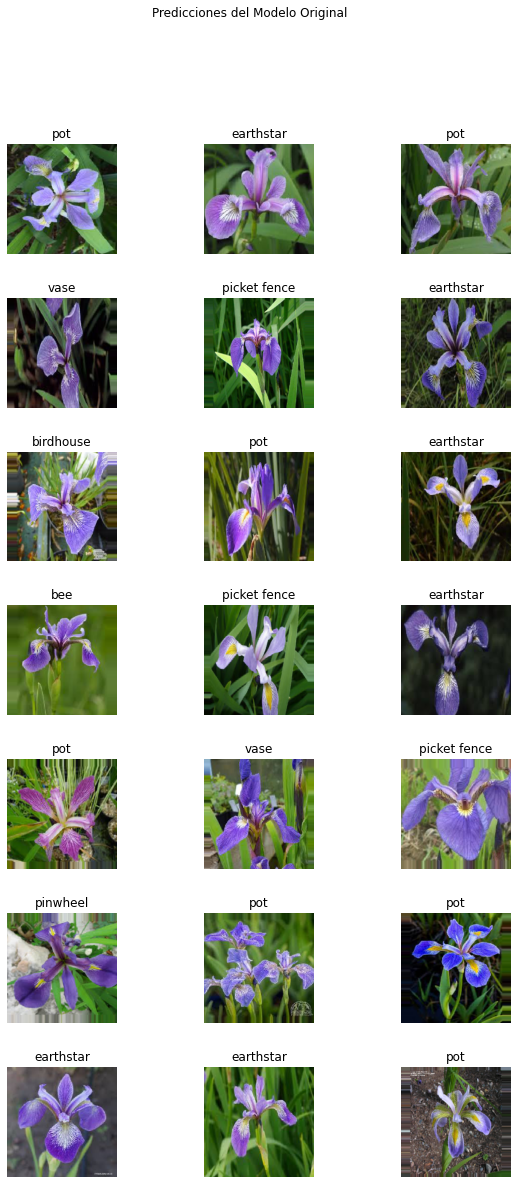

In [ ]:
#@title Probar modelo sin re-entrenar

# ejecuta el modelo
result_batch = classifier.predict(image_batch)

# determina resultados
predicted_class_names = model_imagenet_labels[np.argmax(result_batch, axis=-1)]

# muestra resultados
plt.figure(figsize=(10,19))
plt.subplots_adjust(hspace=0.4)
col = 3
rows=len(image_batch)//col

_ = plt.suptitle("Predicciones del Modelo Original")
for n in range(col*rows):
  plt.subplot(rows,col,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')


6) Re-entrenar el modelo:

In [ ]:
#@title Preparar el modelo a re-entrenar

# Obtiene el modeo base del modelo para usar en el re-entrenamiento, congelandolo
# y agregandole una nueva capa para aprender las nuevas clases

# Create the feature extractor
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SHAPE+(3,))

# It returns a 1280-length vector for each image:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

# Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.
feature_extractor_layer.trainable = False

# Attach a classification head
model = tf.keras.Sequential([ feature_extractor_layer, 
                             layers.Dense(image_data.num_classes, activation='softmax') ])

# Use compile to configure the training process
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'] )

# nuevo modelo a re-entrenar
print("\n")
model.summary()

# info de imágenes a aprender
print("\n")
predictions = model(image_batch)
predictions.shape

(23, 2048)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________




TensorShape([23, 3])

In [ ]:
#@title Re-Entrenar

# ejecucuta el re-entrenamiento del modelo

# functions to visualize the training progress
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

# ejecuta el entrenamiento
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=35,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

print("\nModelo re-entrenado")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1876: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
1/1 [==============================] - 8s 8s/step - loss: 1.1446 - acc: 0.3913
Epoch 2/35
1/1 [==============================] - 4s 4s/step - loss: 0.9921 - acc: 0.4783
Epoch 3/35
1/1 [==============================] - 4s 4s/step - loss: 1.0460 - acc: 0.5217
Epoch 4/35
1/1 [==============================] - 4s 4s/step - loss: 0.9783 - acc: 0.5217
Epoch 5/35
1/1 [==============================] - 4s 4s/step - loss: 0.8825 - acc: 0.6957
Epoch 6/35
1/1 [==============================] - 4s 4s/step - loss: 0.8951 - acc: 0.6957
Epoch 7/35
1/1 [==============================] - 4s 4s/step - loss: 0.8652 - acc: 0.7391
Epoch 8/35
1/1 [==============================] - 4s 4s/step - loss: 0.8158 - acc: 0.7391
Epoch 9/35
1/1 [==============================] - 4s 4s/step - loss: 0.7610 - acc: 0.7826
Epoch 10/35
1/1 [==============================] - 4s 4s/step - loss: 0.6750 - acc: 0.9130
Epoch 11/35
1/1 [==============================] - 4s 4s/step - loss: 0.6622 - acc: 0.8696
Epoch 12

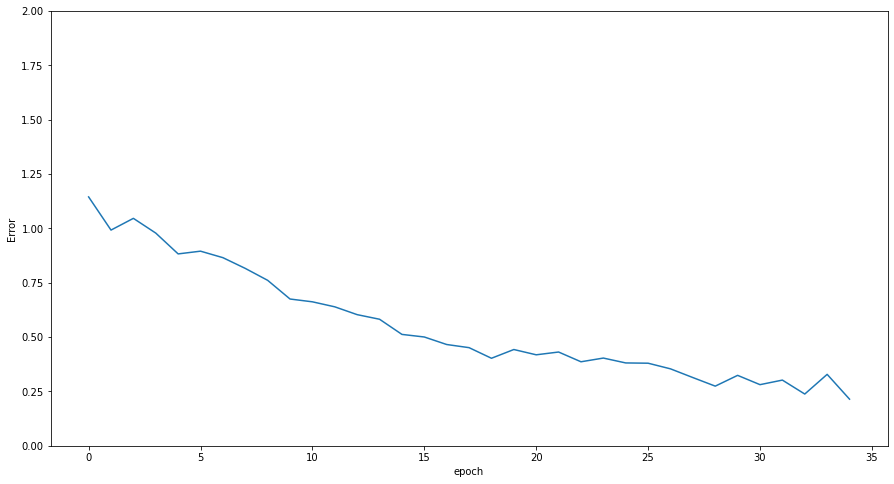

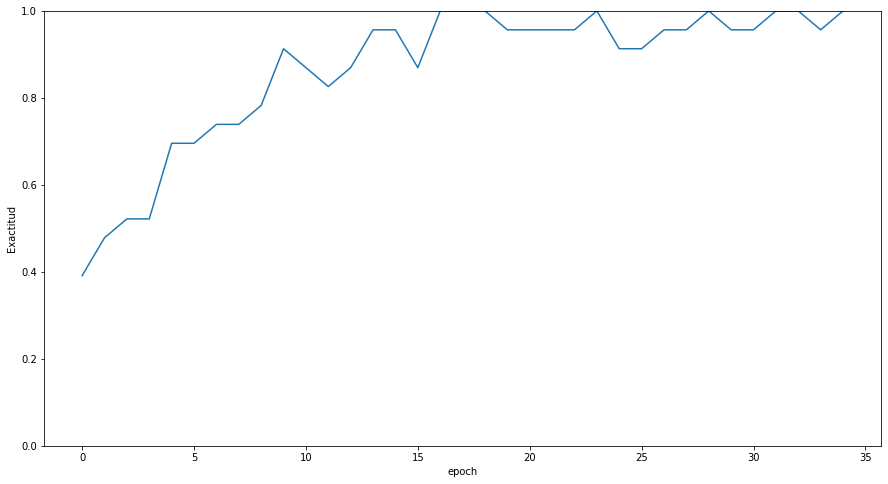

In [ ]:
#@title Mostrar gráficos del re-entrenamiento
# muestra gráficos con resultados del re-entrenamiento
plt.figure(figsize=(15,8)) 
plt.ylabel("Error")
plt.xlabel("epoch")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure(figsize=(15,8)) 
plt.ylabel("Exactitud")
plt.xlabel("epoch")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

7) Probar nuevo modelo re-entrenado:

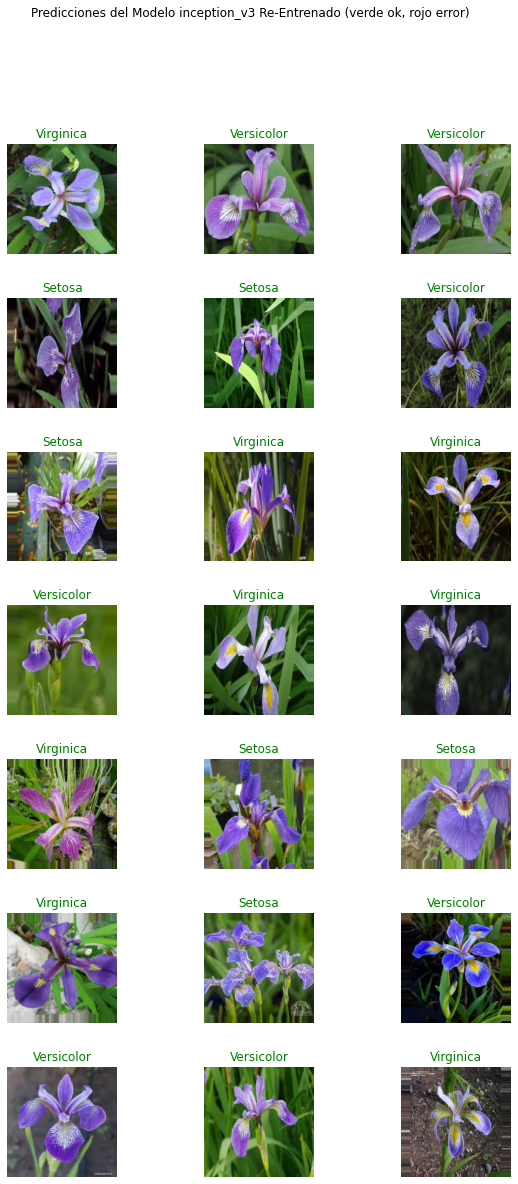

In [ ]:
#@title Probar el modelo re-entrenado

# ejecuta el modelo re-entrenado
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_batch, axis=-1)

# muestra resultados
plt.figure(figsize=(10,19))
plt.subplots_adjust(hspace=0.4)
col = 3
rows = len(image_batch)//col

for n in range(col*rows):
  plt.subplot(rows,col,n+1)
  plt.imshow(image_batch[n])
  if  predicted_id[n] == label_id[n]:
    color = "green"  
    res = class_names[predicted_id[n]]
  else:
    color = "red"
    res = class_names[predicted_id[n]] + ' [real ' + class_names[label_id[n]] + ']' 

  plt.title(res, color=color)
  plt.axis('off')
_ = plt.suptitle('Predicciones del Modelo ' + modeloUsar + ' Re-Entrenado (verde ok, rojo error)')


8) Grabar el modelo re-entrenado:

In [ ]:
#@title Grabar el modelo re-entrenado

# exporta modelo reentrenado
model.save(model_export_path, save_format='tf')
print("\nModelo grabado en ", model_export_path)

# exporta definición de tamaño de imágenes
with open( model_export_path + '/imagshape.csv', mode='w') as csvfile:
    wr = csv.writer(csvfile)
    wr.writerow(IMAGE_SHAPE)

# exporta definición de las clases
with open( model_export_path + '/clases.csv', mode='w') as csvfile:
    wr = csv.writer(csvfile)
    wr.writerow(class_names)
print('Definición de las clases: ', class_names, ' grabada')


INFO:tensorflow:Assets written to: gdrive/My Drive/IA/demo IRIS//Model_TFHub/assets

Modelo grabado en  gdrive/My Drive/IA/demo IRIS//Model_TFHub
Definición de las clases:  ['Setosa' 'Versicolor' 'Virginica']  grabada
